In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype

DATA_FOLDER = "dataset"

In [36]:
df = pd.read_csv(os.path.join(DATA_FOLDER, "preprocessed_df.csv"))
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

## Outliers using KNN

In [66]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
import networkx as nx 
n_neighbors = 5
normalized_df=(df[numerical_attr_list]-df[numerical_attr_list].min())/(df[numerical_attr_list].max()-df[numerical_attr_list].min())
G = kneighbors_graph(normalized_df.values, n_neighbors=n_neighbors, mode="distance", p=np.inf)
G = nx.DiGraph(G)
dictator = nx.to_dict_of_dicts(G);

In [67]:
score = np.zeros(len(normalized_df))
for element in dictator.keys():
    mean_dist = 0
    for child in dictator[element].keys():
        mean_dist += dictator[element][child]["weight"]/n_neighbors
    score[element] = mean_dist

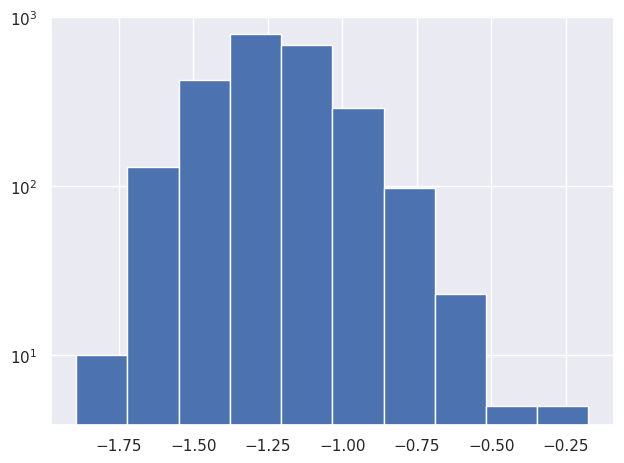

In [68]:
plt.hist(np.log(score));
plt.yscale("log")

In [69]:
from sklearn.manifold import Isomap

reducer = Isomap(n_neighbors=n_neighbors)
embedding = reducer.fit_transform(normalized_df)

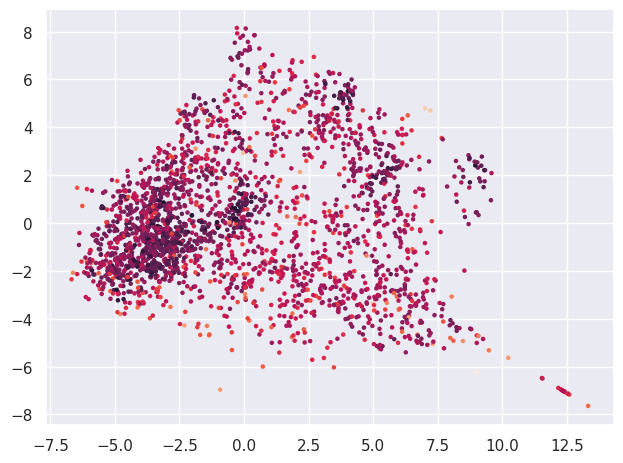

In [70]:
plt.scatter(*embedding.T, c=np.log(score), s=5)

<Axes: >

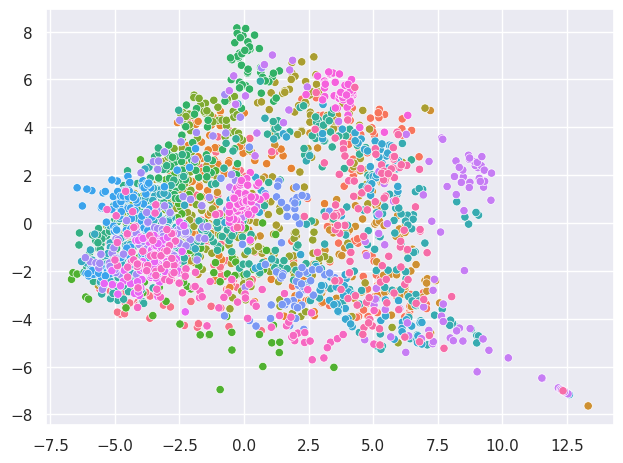

In [71]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["actor"], legend=False)

<Axes: >

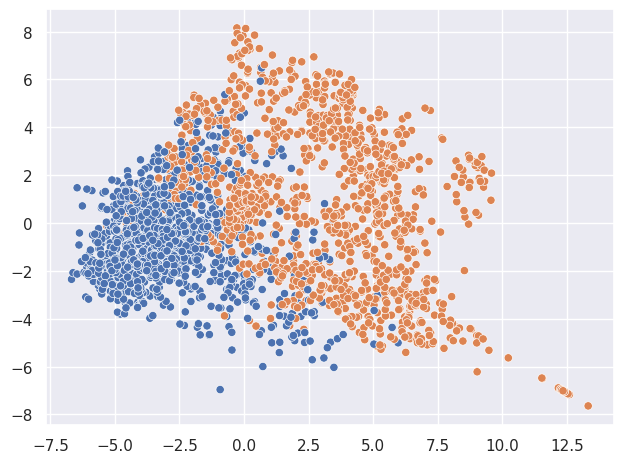

In [72]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["sex"], legend=False)

<Axes: >

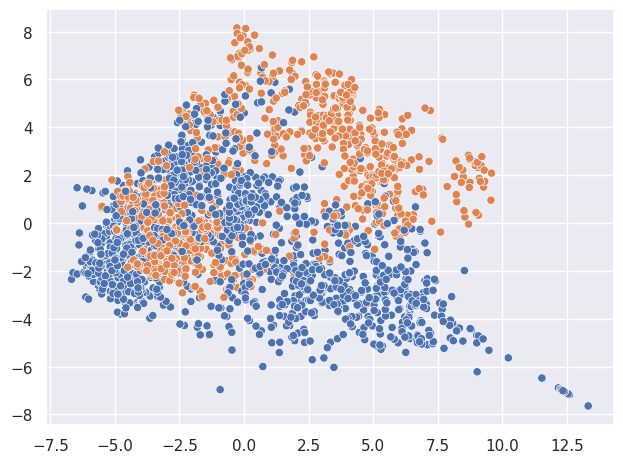

In [73]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["vocal_channel"], legend=False)

<Axes: >

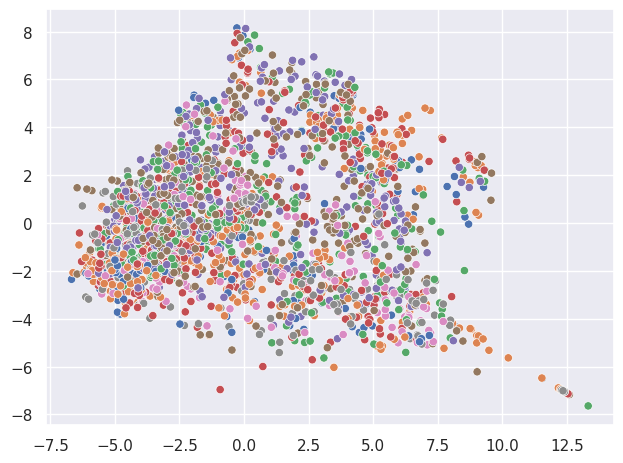

In [74]:
sns.scatterplot(x = embedding[:,0], y=embedding[:,1], hue=df["emotion"], legend=False)